In [58]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime

#For reproducability
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Some functions to help out with
def plot_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} ED Arrivals')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} ED Arrivals')
    plt.title(f'{symbol} ED Arrivals Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{symbol} ED Arrivals')
    plt.legend()
    plt.show()

def plot_return_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} ED Arrivals Returns')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} ED Arrivals Returns')
    plt.title(f'{symbol} ED Arrivals Return Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{symbol} ED Arrivals Returns')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
#    raw_data = YahooFinancials(ticker)
#    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

#def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
#    date_range = pd.bdate_range(start=start_date, end=end_date)
#    values = pd.DataFrame({'Date': date_range})
#    values['Date'] = pd.to_datetime(values['Date'])
#    raw_data = get_ticker_data(ticker, start_date, end_date)
#    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]

def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e

<ipython-input-58-7351a065fdc0>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Get the Data

In [28]:
import pandas as pd
url='https://raw.githubusercontent.com/wujinja-cgu/Time-Series-Analysis/main/time%20series%20data.csv'
df = pd.read_csv(url, index_col='DATE', parse_dates=["DATE"])
df.head()

,No
DATE,
2007-10-09,325
2007-10-10,417
2007-10-11,556
2007-10-12,467
2007-10-13,430


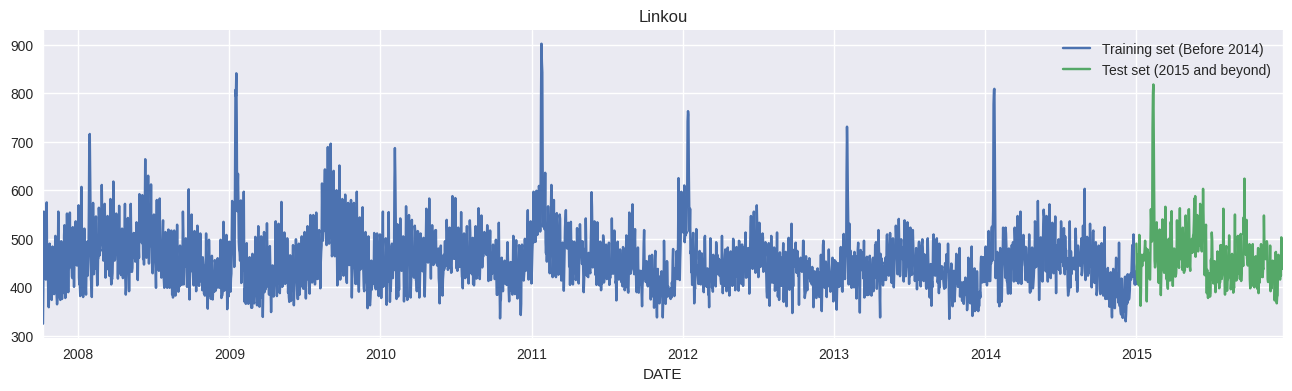

In [29]:
import matplotlib.pyplot as plt
# Plot the training set
df["No"][:'2014'].plot(figsize=(16, 4), legend=True)
# Plot the test set
df["No"]['2015':].plot(figsize=(16, 4), legend=True)
plt.legend(['Training set (Before 2014)', 'Test set (2015 and beyond)'])
plt.title('Linkou')
plt.show()

In [30]:
# We have chosen the target as 'Close' attribute for prices. Let's see what it looks like
# here we are seperating the data
training_set = df[:'2014'].iloc[:,0:1].values
test_set = df['2015':].iloc[:,0:1].values

print(training_set.shape)
print(test_set.shape)

(2641, 1)
(355, 1)


In [31]:
# Scaling the training set - I've tried it without scaling and results are very poor.
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)


In [61]:
timesteps = 10
# First, we create data sets where each sample has with 8 timesteps and 1 output
# So for each element of training set, we have 8 previous training set elements
x_train = []
y_train = []
for i in range(timesteps,training_set.shape[0]):
    x_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train[0], y_train[0])
print(x_train[1], y_train[1])

[0.         0.15944541 0.40034662 0.24610052 0.18197574 0.18890815
 0.18890815 0.15771231 0.24263432 0.43327556] 0.1854419410745234
[0.15944541 0.40034662 0.24610052 0.18197574 0.18890815 0.18890815
 0.15771231 0.24263432 0.43327556 0.18544194] 0.25823223570190634


### The choice of the number of timesteps is the first thing worth noting. This is also true with RNNs, but with transformers - the optimum choice is often much lower. Three stocks are shown below. With RNNs the number ranges much higher. For ConvLSTMs the optimum is usually between 40-90 timesteps, with transformers it is usually under 10.

In [62]:
print(x_train.shape, y_train.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(2631, 10) (2631,)
(2631, 10, 1) (2631,)


In [63]:
print(x_train.shape, y_train.shape)
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

(2631, 10, 1) (2631,)


# Build the model

### Our model processes a tensor of shape [batch size, sequence length, features], where sequence length is the number of time steps in your sample and features is the number of elements you are trying to predict. If we are only trying to predict one thing, such as closing price - then features is 1. When it comes to describing tensor shapes, I am going to refer to batch size as "#samples" so as not to confuse it with batch_size when fitting the model.

### Fortunately, with recurrent neural nets (such as LSTMs) for timeseries analysis, the inputs [#samples, timesteps, features] are compatible with transformers!
#### The image below is for a single transformer encoder block. For our purposes, the embedding is removed and limited to only to a LayerNormalization layer (which does work better than a BatchNormalization layer). The positional embedding is an option, but frankly - I have tried three diferent time2vec implementations and although the code works, the results are worse (If you can implement a time2vec function which actually improves the rmse score then please share with me). The multi-head attention is already coded for in keras. The feed forward part can be almost anything. We will use a Conv1D layer(because results are good) but you could get away with almost anything, dense layers, another LSTM, whatever you want. You could also stick an LSTM in the embedding layer - it works, if your return_sequences = True, it just give worse results.

<center>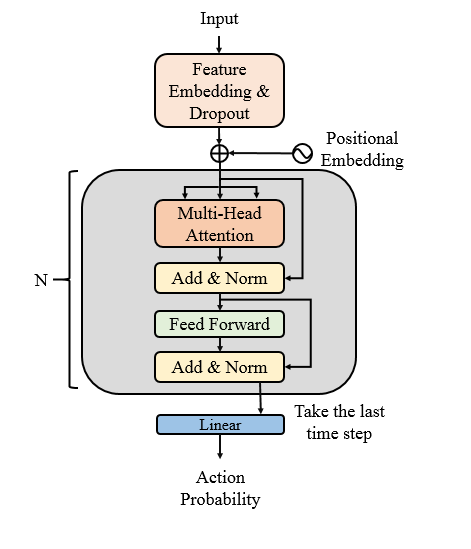</center>

In [64]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work.
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

### The main part of our model is now complete.
### We can stack multiple of those transformer_encoder blocks and we can also proceed to add the final Multi-Layer Perceptron/ DNN head.

### Apart from a stack of Dense layers, we need to reduce the output tensor of the TransformerEncoder part of our model down to a vector of features for each data point in the current batch. A pooling layer like GlobalAveragePooling1D layer will do this.

In [36]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

### Another note - the activation function above makes a difference, elu is best : elu > selu > tanh > relu > gelu > swish. I am curious if serlu would out perform them but I can't figure out how to add the custom activation function.

In [65]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [66]:
callbacks = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.LearningRateScheduler(lr_scheduler)
      ]

In [67]:
input_shape = x_train.shape[1:]
print(input_shape)

(10, 1)


In [68]:
model = build_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14)

In [69]:
model.compile(
       loss="mean_squared_error",
       optimizer=keras.optimizers.Adam(learning_rate=1e-4),
       metrics=["mean_squared_error"],
)

In [70]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 10, 1)]              0         []                            
                                                                                                  
 layer_normalization_10 (La  (None, 10, 1)                2         ['input_2[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_5 (Mu  (None, 10, 1)                19321     ['layer_normalization_10[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'layer_normalization_10

In [71]:
history = model.fit(
            x_train,
            y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=callbacks
)

Epoch 1/100
66/66 [==============================] - 36s 402ms/step - loss: 0.2376 - mean_squared_error: 0.2376 - val_loss: 0.2134 - val_mean_squared_error: 0.2134 - lr: 1.0000e-06
Epoch 2/100
66/66 [==============================] - 25s 387ms/step - loss: 0.0656 - mean_squared_error: 0.0656 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - lr: 3.4300e-05
Epoch 3/100
66/66 [==============================] - 22s 337ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - lr: 6.7600e-05
Epoch 4/100
66/66 [==============================] - 25s 386ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - lr: 1.0090e-04
Epoch 5/100
66/66 [==============================] - 22s 339ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - lr: 1.3420e-04
Epoch 6/100
66/66 [==============================] - 23s 342ms/step - loss: 0.0215 - mean_squar

# Evaluate model

In [72]:
dataset_total = pd.concat((df['No'][:2641],df['No'][2641:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.fit_transform(inputs)

In [73]:
dataset_total

DATE
2007-10-09    325
2007-10-10    417
2007-10-11    556
2007-10-12    467
2007-10-13    430
             ... 
2015-12-17    503
2015-12-18    444
2015-12-19    438
2015-12-20    471
2015-12-21    452
Name: No, Length: 2996, dtype: int64

In [74]:
X_test = []
for i in range(timesteps,test_set.shape[0] + timesteps):
    X_test.append(inputs[i-timesteps:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_ED_Arrivals = model.predict(X_test)
predicted_ED_Arrivals = sc.inverse_transform(predicted_ED_Arrivals)
predicted_ED_Arrivals

12/12 [==============================] - 2s 90ms/step


array([[465.62878],
       [466.34988],
       [428.68008],
       [414.01578],
       [448.12366],
       [421.92465],
       [457.56094],
       [450.41974],
       [462.5978 ],
       [446.41916],
       [449.05664],
       [392.15158],
       [413.4505 ],
       [452.30356],
       [487.63632],
       [450.68472],
       [425.68634],
       [421.24146],
       [447.9911 ],
       [480.5385 ],
       [469.74826],
       [461.5294 ],
       [483.3065 ],
       [472.5753 ],
       [466.0326 ],
       [444.16223],
       [418.5039 ],
       [450.6712 ],
       [480.75186],
       [469.83334],
       [454.83728],
       [420.5417 ],
       [424.8455 ],
       [446.83313],
       [457.3223 ],
       [472.47455],
       [505.2133 ],
       [496.42554],
       [479.73175],
       [456.88263],
       [582.1884 ],
       [681.30334],
       [707.5297 ],
       [608.3188 ],
       [510.10632],
       [488.95798],
       [578.21234],
       [589.79346],
       [558.4579 ],
       [493.8775 ],


In [75]:
print(test_set[-3],test_set[-2], test_set[-1])

[438] [471] [452]


In [76]:
def shift(xs, n):
    e = np.empty_like(xs, dtype=float)  # Set the data type to float
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = xs[-n:]
        e[:n] = np.nan
    return e

shifted_test_set = shift(test_set, 1) #The shift function is defined early in the notebook
print(shifted_test_set[-3],shifted_test_set[-2], shifted_test_set[-1])

[444.] [438.] [471.]


In [80]:
print(predicted_ED_Arrivals[-1])
prediction_error = test_set - predicted_ED_Arrivals # This is the error on the same day
#Before we can calculate the predicted return we have to shift the test_set to the day before so we use the shifted_test_set
predicted_return = (shifted_test_set - predicted_ED_Arrivals) / shifted_test_set

[451.22852]


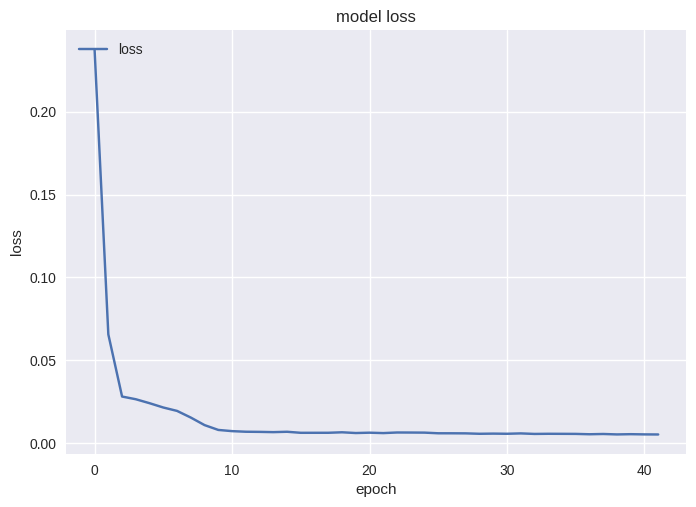

In [81]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

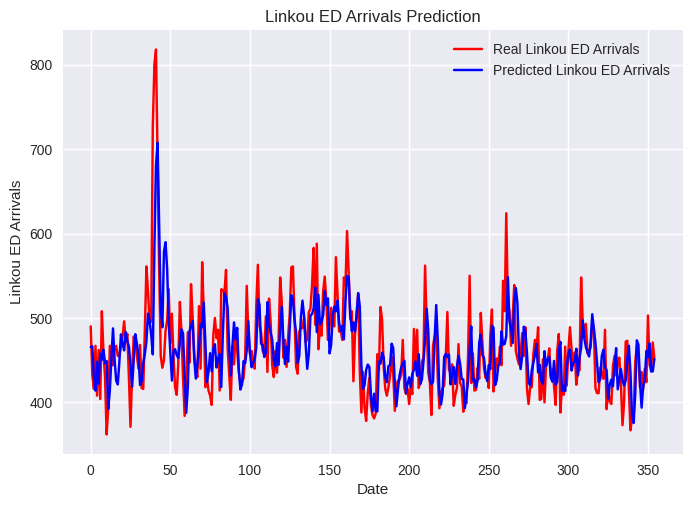

The root mean squared error is 41.75905048144737.


41.75905048144737

In [82]:
original_symbol= 'Linkou'
plot_predictions(test_set,predicted_ED_Arrivals,original_symbol)
return_rmse(test_set,predicted_ED_Arrivals)

In [87]:
# calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

testmape = mape(test_set,predicted_ED_Arrivals)
print('Test MAPE for transformers: %.2f' % (testmape) ,'where 5.85 for LSTM')

Test MAPE for transformers: 6.33 where 5.85 for LSTM


In [89]:
# calculate MAE
def mae(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)))

testmae = mae(test_set,predicted_ED_Arrivals)
print('Test MAE for transformers: %.2f' % (testmae), 'where 27.40 for LSTM')

Test MAE for transformers: 29.89 where 27.40 for LSTM
